# 04 Region Classification

Author: Harry Yau

Date: Sept 1, 2019

Packages that needs to be installed:
- CatBoost
- geopandas

Warning: it is not suggested to re-run this Notebook. When running the logistic regression, you may run out of RAM. In addition, training the models without GPU may take a very long time due to ~900K rows in training and ~200K rows in the validation set.

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

import re
import seaborn as sns
import datetime
from datetime import timedelta

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
data_folder = 'data'
pickle_folder = 'pickle'
shp_folder = 'shp_files'

#load station data
station_info_df = pd.read_csv(data_folder + '/' + 'station_data.csv', dtype={'id': str, 'name': str, 'lat': float, 'lon': float, 'total_slots':int})

def load_pickle(url):
    '''
    Function to load pickle file
    '''
    infile = open(url, 'rb')
    data = pickle.load(infile)
    infile.close()
    return data

filename = 'mobi_cleaned.pkl'
combined_df = load_pickle(pickle_folder + '/' + filename)

filename = 'YVR_wxdata.pkl'
weather_df = load_pickle(pickle_folder + '/' + filename)

In [3]:
#Converts lat lon to the correct projection corrdinates.

from pyproj import Proj, transform

inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:26910')

lon=[]
lat=[]
for i in range(0, len(station_info_df)):
    out = transform(inProj,outProj, station_info_df['lon'][i], station_info_df['lat'][i])
    lon.append(out[0])
    lat.append(out[1])
    
    
station_info_df['lat_conv'] = lat
station_info_df['lon_conv'] = lon

del lat, lon

In [4]:
stanley_park_index = ['0103', '0105','0101','0209','0102','0104', ]
main_knight_index = ['0199', '0213', '0221', '0227', '0229', 
                    '0233', '0234',  '0236', '0237', '0238',  '0246', '0248', 
                    '0255', '0256', '0257', '0258', '0260', '0261',
                    '0262', '0265', '0266',  '0281',
                    '0282',   '0287', '0297', '0298', '0179']
knight_comm_index = ['0280', '0285', '0225', '0224', '0272', '0222', '0223', '0232', 
                    '0231', '0253', '0235', '0239', '0252', '0240', '0250', '0241',
                    '0273', '0249', '0254', '0242', '0245', '0244', '0274', '0283', '0278']
southern_fc_seawall_west_index = ['0204', '0154', '0155', '0147', '0077', '0066']
southern_fc_seawall_east_index=[ '0143', '0010', '0009', '0173', '0174', '0006', '0011', '0177' ]
eastern_fc_seawall_index = ['0193', '0148', '0218', '0054']
northern_fc_seawall_west_index = ['0083', '0084', '0060', '0028', '0031', '0047', '0028', '0031']
northern_fc_seawall_east_index = ['0057', '0017', '0136', '0137', ]
coal_harbor_seawall_index=['0035', '0034', '0201', '0014']
dt_westend_index = ['0092', '0093', '0032', '0033', '0041', '0040', '0096', '0048', '0087', '0088', '0187', '0050', '0036', '0207', '0123', '0126', '0190', ]
dt_core_index = ['0016', '0002', '0024', '0021', '0099', '0019', '0063', '0015','0129', '0012', '0125', '0025']
dt_southern_corridor_index = ['0037', '0039', '0089', '0196', '0082', '0079', '0058', '0138']
dt_yaletown_index = ['0004', '0078', '0027', '0064', '0026', '0044']
dt_gastown_chinatown_index = ['0052', '0030', '0167', '0150', '0098', '0005', '0053', '0055', '0161', '0230',]
granville_west_index = ['0113', '0115', '0152', '0114', '0203', '0071',
                        '0070', '0205', '0068',  '0208', '0109', '0140', '0069',
                        '0153', '0139', '0076', '0110', '0159', '0108', '0065']
granville_east_index = ['0211', '0202', '0166', '0112', '0080', '0191', '0192', '0081', '0008',
                        '0106', '0130', '0001', '0007', '0072', '0172', '0180', '0171', '0165', 
                        '0073', '0119', '0107', '0176', '0132', '0133', '0134', '0074', '0206',
                        '0198', '0197']


#Check if we accounted for all the stations
index_list = [stanley_park_index,
                southern_fc_seawall_west_index,
                southern_fc_seawall_east_index,
                eastern_fc_seawall_index,
                northern_fc_seawall_west_index,
                northern_fc_seawall_east_index,
                coal_harbor_seawall_index,
                dt_westend_index,
                dt_core_index,
                dt_southern_corridor_index,
                dt_yaletown_index,
                dt_gastown_chinatown_index,
                granville_west_index,
                granville_east_index,
                main_knight_index,
                knight_comm_index,]


ind = sum(index_list, [])

station_info_df['id'].isin(ind).sum() == station_info_df.shape[0]

region_label_df = pd.DataFrame({'id': range(0,len(index_list)), 'Name':
    ['Stanley Park', 'Seawall - Southern False Creek West',  'Seawall - Southern False Creek East',
    'Seawall - Eastern False Creek', 'Seawall - Northern False Creek West', 'Seawall - Northern False Creek East',
     'Seawall - Coal Harbour',
    'Downtown - West End', 'Downtown - Core', 'Downtown - Southern Corridor', 'Downtown - Yaletown',
    'Gastown - Chinatown - Railtown', 'Kitsilano', 'Mount Pleasant', 'Main - Knight', 'Knight - Commercial' ]
    })


station_info_df['Region Name'] = ''
station_info_df['Region'] = ''

for i, val in enumerate(index_list):
    station_info_df.loc[station_info_df['id'].isin(val), 'Region'] = i
    station_info_df.loc[station_info_df['id'].isin(val), 'Region Name'] = region_label_df.loc[i, 'Name']    


### Compile Features

In [5]:
group_1 = ['24 Hour',
           'Archived Day',  
           'Archived Single Trip Pass',]

group_2 = ['90 Day',
          'Archived Monthly Plus',
          'Archived Monthly Standard', 
          'Archived Monthly Basic',]

group_3 = ['365 Day Founding Plus', 
          '365 Standard',
          '365 Day Founding Standard', 
          '365 Plus', 
          '365 Corporate Plus', 
          '365 Corporate Plus Renewal', 
          '365 Corporate Standard Renewal',
          '365 Day Pass Plus SALE',
          '365 Corporate Standard', 
          '365 Day Pass Standard SALE',
          'Vancity Community Pass',
          'Archived Founding Standard', 
          'Archived Founding Plus',
          'VIP', ]

In [6]:
def get_portion_of_day(hour):
    '''
    Label different parts of the day.
    '''
    output = None
  
    #Converts the hour to integer
    if (isinstance(hour, str)):
        hour = int(hour)
  

    if (5 <= hour <= 11):
        output = 'Morning'
    elif (12 <= hour <= 18):
        output = 'Afternoon'
    elif (19 <= hour <= 22):
        output = 'Evening'
    else:
        output = 'Night'

    return output

### Compile the DataFrame with Features

In [7]:
target_col_compile = ['Departure', 'Departure station', 'Return station', 'Membership Type', 'Account']

stations_df = combined_df.reindex(target_col_compile, axis=1)
stations_df = pd.merge(stations_df, station_info_df.reindex(['id', 'Region'], axis=1), 
                       how='inner', left_on='Departure station', right_on='id',)
stations_df = pd.merge(stations_df, station_info_df.reindex(['id', 'Region'], axis=1), 
                       how='inner', left_on='Return station', right_on='id',
                       suffixes=['_Departure', '_Return'])
stations_df.drop(columns=['id_Departure', 'id_Return'], inplace=True)



#========================================== Assemble variables ==============================

stations_df['Hour'] = stations_df['Departure'].dt.strftime('%H')
stations_df['Month'] = stations_df['Departure'].dt.strftime('%b')

stations_df['day_of_week'] = stations_df['Departure'].dt.dayofweek
stations_df.loc[(stations_df['day_of_week'] == 0),'day_of_week'] = 'Monday'
stations_df.loc[(stations_df['day_of_week'] == 1),'day_of_week'] = 'Tuesday'
stations_df.loc[(stations_df['day_of_week'] == 2),'day_of_week'] = 'Wednesday'
stations_df.loc[(stations_df['day_of_week'] == 3),'day_of_week'] = 'Thursday'
stations_df.loc[(stations_df['day_of_week'] == 4),'day_of_week'] = 'Friday'
stations_df.loc[(stations_df['day_of_week'] == 5),'day_of_week'] = 'Saturday'
stations_df.loc[(stations_df['day_of_week'] == 6),'day_of_week'] = 'Sunday'

stations_df['Weekday'] = stations_df['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype(int)
stations_df['Weekend'] = stations_df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

print(stations_df.shape)

stations_df['Date_day'] = stations_df['Departure'].dt.to_period('D')
stations_df['Date_year'] = stations_df['Departure'].dt.to_period('Y')

#Add portion of the day classifier. 'Morning', 'Afternoon', 'Evening', 'Night'
stations_df['DAY_PORTION'] = stations_df['Hour'].map(get_portion_of_day)

stations_df['Membership Group'] = stations_df['Membership Type']
stations_df.loc[stations_df['Membership Group'].isin(group_1), 'Membership Group'] = 'Daily'
stations_df.loc[stations_df['Membership Group'].isin(group_2), 'Membership Group'] = 'Monthly'
stations_df.loc[stations_df['Membership Group'].isin(group_3), 'Membership Group'] = '365_Type'

#To one hot the Departure Region.
stations_df['Region_Departure'] = stations_df['Region_Departure'].astype(str)

print(stations_df.shape)

(1293376, 12)


In [11]:
target_col = ['Region_Departure', 
              'Hour', 
              'DAY_PORTION', 
              'Weekday', 'Weekend', 
              
              'Departure station',
              'Membership Type', 
              'Membership Group', 
             ]


train_valid_row = (stations_df['Date_year'] == 2017) | (stations_df['Date_year'] == 2018)

X_onehot = pd.get_dummies(stations_df.loc[:, target_col])

X = X_onehot.loc[train_valid_row,:]
y = stations_df.loc[train_valid_row, 'Region_Return']


test_row = (stations_df['Date_year'] == 2019)
X_test = X_onehot.loc[test_row,:]
y_test = stations_df.loc[test_row, 'Region_Return']


print(X.shape)
print(X_test.shape)

(1181138, 254)
(112238, 254)


Note: Compared to 02 Daily Count Regression, the train, validation and testing split is slightly different. The testing set is all of the 2019 data, and the validation set is randomized 20% of the 2017 and 2018 data.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=88, shuffle=True, stratify=y)


from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()

X_train_NN_scaled = X_scaler.fit_transform(X_train)
X_valid_NN_scaled = X_scaler.transform(X_valid)
X_test_NN_scaled = X_scaler.transform(X_test)

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Functions

In [13]:
def custom_predict(model, X_train, X_valid, X_test, y_scaler=None, NN_conv=False, proba=False, reshape=False):
    '''
    Uses the predict method for a model on the train valid and test set.
    '''
    
    X_list = [X_train, X_valid, X_test]
    y_pred_list = []
    
    for i in range(0,3):
        
        if (proba):
            y_pred = model.predict_proba(X_list[i])
        else:
            y_pred = model.predict(X_list[i])
        
        if (reshape):
            y_pred = y_pred.reshape(1, len(y_pred))[0]
        
        #For Neural networks
        if y_scaler is not None:
            y_pred = y_scaler.inverse_transform(y_pred)

        #For Neural network output, converts the maximum value to binary.
        if (NN_conv):
            y_pred = np.argmax(y_pred, axis=1)

        y_pred_list.append(y_pred)
            
    return y_pred_list

def custom_model_score(y_pred_list, y_train, y_valid, y_test, ctype='Regression'):
    '''
    Calculates the RMSE and R2 metrics
    '''
    
    import math
    from sklearn.metrics import r2_score, mean_squared_error
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
   
    score_output = []
    
    if (ctype == 'Regression'):
        score_output = [
            math.sqrt(mean_squared_error(y_train, y_pred_list[0].round())),
            math.sqrt(mean_squared_error(y_valid, y_pred_list[1].round())),
            math.sqrt(mean_squared_error(y_test, y_pred_list[2].round())),
            r2_score(y_train, y_pred_list[0].round()),
            r2_score(y_valid, y_pred_list[1].round()),
            r2_score(y_test, y_pred_list[2].round())
            ]
    elif (ctype == 'Classification'):
        score_output = []
        
        y_true_list = [y_train, y_valid, y_test]
        
        for i in range(3):
            score_output.append(accuracy_score(y_true_list[i], y_pred_list[i]))
        for i in range(3):
            score_output.append(precision_score(y_true_list[i], y_pred_list[i], average='macro'))
        for i in range(3):
            score_output.append(recall_score(y_true_list[i], y_pred_list[i], average='macro'))
        for i in range(3):
            score_output.append(f1_score(y_true_list[i], y_pred_list[i], average='macro'))
    else:
        None

    return (score_output)

def custom_score_display(the_score, index=None, ctype='Regression'):
    
    '''
    If a list of index is provided, it will expect the first argument to be a list to create a combined score.
    '''

    if index is None:
        output_score  = pd.DataFrame([the_score])
    else:
        output_score = pd.DataFrame(the_score)
        output_score.index = index
    
    if (ctype=='Regression'):
        output_score.columns = ['Training - RMSE', 'Validation - RMSE', 'Test - RMSE', 'Training - R2', 'Valid - R2', 'Test - R2']
    elif (ctype=='Classification'):
        output_score.columns = ['Training - Accuracy', 'Validation - Accuracy', 'Test - Accuracy', 
                                'Training - Precision', 'Valid - Precision', 'Test - Precision',
                                'Training - Recall', 'Valid - Recall', 'Test - Recall',
                                'Training - F1', 'Valid - F1', 'Test - F1',
                               ]
    else:
        None
    
    return (output_score)

In [14]:
def custom_confusion_matrix(y_actual, y_predicted, region_label_df):
    '''
    Plots the confustion matrix
    '''
        
    cm = pd.crosstab(y_actual, y_predicted)
    cm = cm.reindex(index=region_label_df['id'], columns=region_label_df['id'], fill_value=0)

    cm.columns = region_label_df['Name']
    cm.index = region_label_df['Name']

    plt.figure(figsize=(10,10))
    g = sns.heatmap(cm, annot=True, fmt='g', square=True, cmap=sns.cubehelix_palette(100, start=.5, rot=-.75), cbar=False)
    plt.xlabel('Predicted Return', size=15)
    plt.ylabel('Actual Return', size=15)
    plt.title('Confusion Matrix', size=15)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right') 
    plt.show();

#train and valid has scrambled indexes. Need to regrab the 'Region Departure' information with the correct index or else the tabulation will be incorrect

def custom_departure_return_matrix(y_actual_departure, y_actual_return, y_predicted, region_label_df, model_name=None):
    '''
    Plots the matrix that tabulates the actual departure station location with the actual or predicted return station location.
    '''
    
    g, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=True, figsize=(18,10))
    
    #Left Panel
   
    cm = pd.crosstab(y_actual_departure, y_predicted)
    cm = cm.reindex(index=region_label_df['id'], columns=region_label_df['id'], fill_value=0)
    cm.columns = region_label_df['Name']
    cm.index = region_label_df['Name']

    sns.heatmap(cm, annot=True, fmt='g', square=True, cmap=sns.cubehelix_palette(100, start=.5, rot=-.75), cbar=False, ax=ax1)
    ax1.set_xlabel('Predicted Return', fontsize=15)
    ax1.set_ylabel('Actual Departure', fontsize=15)
    if model_name is None:
        ax1.set_title('Model', fontsize=15)
    else:
        ax1.set_title(model_name, fontsize=15)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
    
    #Right Panel
    
    cm = pd.crosstab(y_actual_departure, y_actual_return)
    cm = cm.reindex(index=region_label_df['id'], columns=region_label_df['id'], fill_value=0)
    cm.columns = region_label_df['Name']
    cm.index = region_label_df['Name']

    sns.heatmap(cm, annot=True, fmt='g', square=True, cmap=sns.cubehelix_palette(100, start=.5, rot=-.75), cbar=False, vmax=9000, ax=ax2)
    ax2.set_xlabel('Actual Return', fontsize=15)
    ax2.tick_params(left=False)
    ax2.set_ylabel('')
    ax2.set_title('Actual', fontsize=15)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')  

In [15]:
y_actual_departure = stations_df['Region_Departure'].astype(int).loc[y_test.index].reset_index(drop=True)
y_actual_return = stations_df['Region_Return'].astype(int).loc[y_test.index].reset_index(drop=True)

### Determining Features for the Model

### The Setup

Unlike the first part of the capstone project, it was discovered that external factors such as the weather and features related to time didn't help with the accuracy scores of the model. Only when features that were related to users detail were included did the accuracy score increase. The analysis is structured into 3 incremental groups of features:
- Base Vanilla Features: Region_Departure, Hour, DAY_PORTION, Weekday, Weekend
- First Addition: Departure station
- Second Addition: Membership Type, Membership Group

The model that was used to do the comparison was a 1 hidden layer Neural Network with 512 neurons, with a 0.4 Drop Out and a Batch Normalization layer. Please see the next section for the explaination of the value of using a more complex model.

### Results

The result is that including features that were more granular and related to user information provided an increase in the accuracy score. The accuracy scores increased from 29.38% to 37.27%. 

#### Base Vanilla Features

In [20]:
target_col = ['Region_Departure', 
              'Hour', 
              'DAY_PORTION', 
              'Weekday', 'Weekend', 
             ]


train_valid_row = (stations_df['Date_year'] == 2017) | (stations_df['Date_year'] == 2018)

X_onehot = pd.get_dummies(stations_df.loc[:, target_col])

X = X_onehot.loc[train_valid_row,:]
y = stations_df.loc[train_valid_row, 'Region_Return']


test_row = (stations_df['Date_year'] == 2019)
X_test = X_onehot.loc[test_row,:]
y_test = stations_df.loc[test_row, 'Region_Return']


print(X.shape)
print(X_test.shape)

(1181138, 46)
(112238, 46)


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=88, shuffle=True, stratify=y)


from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()

X_train_NN_scaled = X_scaler.fit_transform(X_train)
X_valid_NN_scaled = X_scaler.transform(X_valid)
X_test_NN_scaled = X_scaler.transform(X_test)

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [22]:
NN_model_1 = Sequential()
NN_model_1.add(Dense(512, input_dim=X.shape[1], activation='relu'))
NN_model_1.add(Dropout(0.4))
NN_model_1.add(BatchNormalization())
NN_model_1.add(Dense(16, activation="softmax"))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
NN_model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer=adam,
              metrics=["accuracy"])


es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                   verbose=0, mode='auto', baseline=None, restore_best_weights=True)


history = NN_model_1.fit(X_train_NN_scaled, y_train, epochs=200, verbose=1, batch_size=512, 
                       validation_data=(X_valid_NN_scaled, y_valid), shuffle=True, callbacks=[es])

Train on 944910 samples, validate on 236228 samples
Epoch 1/200
944910/944910 [==============================] - 10s 10us/step - loss: 2.2807 - acc: 0.2798 - val_loss: 2.2243 - val_acc: 0.2911
Epoch 2/200
944910/944910 [==============================] - 9s 10us/step - loss: 2.2369 - acc: 0.2886 - val_loss: 2.2213 - val_acc: 0.2912
Epoch 3/200
944910/944910 [==============================] - 10s 10us/step - loss: 2.2334 - acc: 0.2894 - val_loss: 2.2189 - val_acc: 0.2923
Epoch 4/200
944910/944910 [==============================] - 10s 10us/step - loss: 2.2317 - acc: 0.2903 - val_loss: 2.2185 - val_acc: 0.2921
Epoch 5/200
944910/944910 [==============================] - 9s 10us/step - loss: 2.2302 - acc: 0.2907 - val_loss: 2.2182 - val_acc: 0.2931
Epoch 6/200
944910/944910 [==============================] - 10s 10us/step - loss: 2.2289 - acc: 0.2908 - val_loss: 2.2171 - val_acc: 0.2932
Epoch 7/200
944910/944910 [==============================] - 10s 10us/step - loss: 2.2282 - acc: 0.2908 

In [23]:
NN_1_y_pred_list = custom_predict(NN_model_1, X_train_NN_scaled, X_valid_NN_scaled, X_test_NN_scaled, NN_conv=True)

In [25]:
output_1 = custom_score_display(custom_model_score(NN_1_y_pred_list, y_train, y_valid, y_test, ctype='Classification'), 
                              ctype='Classification')
output_1.loc[:,output_1.columns.str.contains('Test')]

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, 

,Test - Accuracy,Test - Precision,Test - Recall,Test - F1
0,0.293795,0.235535,0.243396,0.210711


#### First Addition

In [26]:
target_col = ['Region_Departure', 
              'Hour', 
              'DAY_PORTION', 
              'Weekday', 'Weekend', 
              'Departure station',
             ]


train_valid_row = (stations_df['Date_year'] == 2017) | (stations_df['Date_year'] == 2018)

X_onehot = pd.get_dummies(stations_df.loc[:, target_col])

X = X_onehot.loc[train_valid_row,:]
y = stations_df.loc[train_valid_row, 'Region_Return']


test_row = (stations_df['Date_year'] == 2019)
X_test = X_onehot.loc[test_row,:]
y_test = stations_df.loc[test_row, 'Region_Return']


print(X.shape)
print(X_test.shape)

(1181138, 230)
(112238, 230)


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=88, shuffle=True, stratify=y)


from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()

X_train_NN_scaled = X_scaler.fit_transform(X_train)
X_valid_NN_scaled = X_scaler.transform(X_valid)
X_test_NN_scaled = X_scaler.transform(X_test)

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [28]:
NN_model_1 = Sequential()
NN_model_1.add(Dense(512, input_dim=X.shape[1], activation='relu'))
NN_model_1.add(Dropout(0.4))
NN_model_1.add(BatchNormalization())
NN_model_1.add(Dense(16, activation="softmax"))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
NN_model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer=adam,
              metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                   verbose=0, mode='auto', baseline=None, restore_best_weights=True)


history = NN_model_1.fit(X_train_NN_scaled, y_train, epochs=200, verbose=1, batch_size=512, 
                       validation_data=(X_valid_NN_scaled, y_valid), shuffle=True, callbacks=[es])

Train on 944910 samples, validate on 236228 samples
Epoch 1/200
944910/944910 [==============================] - 14s 15us/step - loss: 2.2046 - acc: 0.2995 - val_loss: 2.1263 - val_acc: 0.3179
Epoch 2/200
944910/944910 [==============================] - 14s 15us/step - loss: 2.1438 - acc: 0.3133 - val_loss: 2.1182 - val_acc: 0.3201
Epoch 3/200
944910/944910 [==============================] - 14s 15us/step - loss: 2.1347 - acc: 0.3154 - val_loss: 2.1110 - val_acc: 0.3222
Epoch 4/200
944910/944910 [==============================] - 15s 16us/step - loss: 2.1292 - acc: 0.3170 - val_loss: 2.1092 - val_acc: 0.3215
Epoch 5/200
944910/944910 [==============================] - 14s 15us/step - loss: 2.1250 - acc: 0.3180 - val_loss: 2.1066 - val_acc: 0.3216
Epoch 6/200
944910/944910 [==============================] - 14s 15us/step - loss: 2.1222 - acc: 0.3189 - val_loss: 2.1044 - val_acc: 0.3233
Epoch 7/200
944910/944910 [==============================] - 14s 15us/step - loss: 2.1193 - acc: 0.319

In [29]:
NN_2_y_pred_list = custom_predict(NN_model_1, X_train_NN_scaled, X_valid_NN_scaled, X_test_NN_scaled, NN_conv=True)

In [30]:
output_2 = custom_score_display(custom_model_score(NN_2_y_pred_list, y_train, y_valid, y_test, ctype='Classification'), 
                              ctype='Classification')
output_2.loc[:,output_2.columns.str.contains('Test')]

,Test - Accuracy,Test - Precision,Test - Recall,Test - F1
0,0.324845,0.306266,0.271693,0.255255


#### Second Addition

In [31]:
target_col = ['Region_Departure', 
              'Hour', 
              'DAY_PORTION', 
              'Weekday', 'Weekend', 
              'Departure station',
              'Membership Type', 
              'Membership Group', 
             ]

train_valid_row = (stations_df['Date_year'] == 2017) | (stations_df['Date_year'] == 2018)

X_onehot = pd.get_dummies(stations_df.loc[:, target_col])

X = X_onehot.loc[train_valid_row,:]
y = stations_df.loc[train_valid_row, 'Region_Return']


test_row = (stations_df['Date_year'] == 2019)
X_test = X_onehot.loc[test_row,:]
y_test = stations_df.loc[test_row, 'Region_Return']


print(X.shape)
print(X_test.shape)

(1181138, 254)
(112238, 254)


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=88, shuffle=True, stratify=y)


from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()

X_train_NN_scaled = X_scaler.fit_transform(X_train)
X_valid_NN_scaled = X_scaler.transform(X_valid)
X_test_NN_scaled = X_scaler.transform(X_test)

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [33]:
NN_model_1 = Sequential()
NN_model_1.add(Dense(512, input_dim=X.shape[1], activation='relu'))
NN_model_1.add(Dropout(0.4))
NN_model_1.add(BatchNormalization())
NN_model_1.add(Dense(16, activation="softmax"))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
NN_model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer=adam,
              metrics=["accuracy"])


es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                   verbose=0, mode='auto', baseline=None, restore_best_weights=True)


history = NN_model_1.fit(X_train_NN_scaled, y_train, epochs=200, verbose=1, batch_size=512, 
                       validation_data=(X_valid_NN_scaled, y_valid), shuffle=True, callbacks=[es])

Train on 944910 samples, validate on 236228 samples
Epoch 1/200
944910/944910 [==============================] - 15s 16us/step - loss: 2.1414 - acc: 0.3211 - val_loss: 2.0253 - val_acc: 0.3517
Epoch 2/200
944910/944910 [==============================] - 15s 15us/step - loss: 2.0432 - acc: 0.3488 - val_loss: 1.9908 - val_acc: 0.3639
Epoch 3/200
944910/944910 [==============================] - 15s 16us/step - loss: 2.0202 - acc: 0.3571 - val_loss: 1.9782 - val_acc: 0.3689
Epoch 4/200
944910/944910 [==============================] - 15s 16us/step - loss: 2.0074 - acc: 0.3614 - val_loss: 1.9667 - val_acc: 0.3735
Epoch 5/200
944910/944910 [==============================] - 16s 17us/step - loss: 1.9976 - acc: 0.3642 - val_loss: 1.9616 - val_acc: 0.3739
Epoch 6/200
944910/944910 [==============================] - 16s 17us/step - loss: 1.9916 - acc: 0.3665 - val_loss: 1.9546 - val_acc: 0.3764
Epoch 7/200
944910/944910 [==============================] - 16s 17us/step - loss: 1.9857 - acc: 0.368

In [34]:
NN_3_y_pred_list = custom_predict(NN_model_1, X_train_NN_scaled, X_valid_NN_scaled, X_test_NN_scaled, NN_conv=True)
output_3 = custom_score_display(custom_model_score(NN_3_y_pred_list, y_train, y_valid, y_test, ctype='Classification'), 
                              ctype='Classification')
output_3.loc[:,output_3.columns.str.contains('Test')]

,Test - Accuracy,Test - Precision,Test - Recall,Test - F1
0,0.372957,0.367716,0.323885,0.318448


In [35]:
output_3

,Training - Accuracy,Validation - Accuracy,Test - Accuracy,Training - Precision,Valid - Precision,Test - Precision,Training - Recall,Valid - Recall,Test - Recall,Training - F1,Valid - F1,Test - F1
0,0.396081,0.386364,0.372957,0.408063,0.390208,0.367716,0.336158,0.325658,0.323885,0.339866,0.327135,0.318448


In [55]:
output = custom_score_display([custom_model_score(NN_1_y_pred_list, y_train, y_valid, y_test, ctype='Classification'), 
              custom_model_score(NN_2_y_pred_list, y_train, y_valid, y_test, ctype='Classification'), 
              custom_model_score(NN_3_y_pred_list, y_train, y_valid, y_test, ctype='Classification')], 
                     index=['One', 'Two', 'Three'], ctype='Classification')

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, 

In [67]:
output

,Training - Accuracy,Validation - Accuracy,Test - Accuracy,Training - Precision,Valid - Precision,Test - Precision,Training - Recall,Valid - Recall,Test - Recall,Training - F1,Valid - F1,Test - F1
One,0.293526,0.293276,0.293795,0.247781,0.254093,0.235535,0.229700,0.230465,0.243396,0.205150,0.205262,0.210711
Two,0.329562,0.325800,0.324845,0.322650,0.305966,0.306266,0.265398,0.261905,0.271693,0.254784,0.250019,0.255255
Three,0.396081,0.386364,0.372957,0.408063,0.390208,0.367716,0.336158,0.325658,0.323885,0.339866,0.327135,0.318448


Text(0, 0.5, 'Accuracy Score')

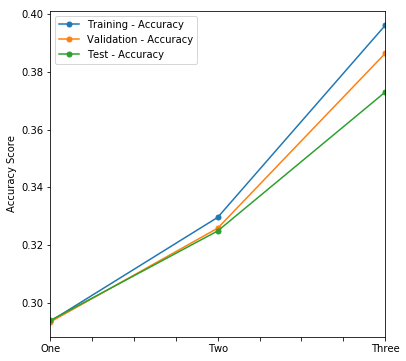

In [66]:
ax = output.iloc[:,:3].plot(figsize=(6,6), style='.-',  markersize=10)

ax.set_ylabel('Accuracy Score')

## Model Comparison

### The Setup

Classification models that were tested ranged from simple to complex. The following classification models were investigated:
- Logistic Regression
- Support Vector Machines
- Gradient Boosting Methods:
    - LightGBM
    - CatBoost
- Neural Network

No formal model tuning was done, besides the Neural Network component where the training and validation loss information was tweaked to make the values become balanced so that the model was not overfitting the training data. Eventually, the neural network parameters were settled on using a 1 hidden layer 512 neuron Neural Network with 0.4 Drop Out and Batch Normalization layer after it. The ultimate goal was to use some reasonable hyperparameters and then do a result comparison.

The model outputs were judged by the accuracy score and the tabulation values of actual departure vs the predicted return station data. For the tabulation value output, the left panel is what the model predicted and the right panel is the actual data in the testing dataset.

### Results

After running the numbers, it appears that the more complex models do better in understanding the interactions between the features. For example when looking at a simple linear model such as a Support Vector Machine, the accuracy score was only 30.2%. When you analyze the tabulation table, the model appears to consistently forecast certain return regions due to high bias in the dataset. There are more predicted ending regions with value zero compared to the actual results. Contrasting this to a more complex model like a Neural Network, the results of the tabulation data are more dispersed. The high bias in the dataset is still apparent in a more complex model, but it was able to learn the interactions of the features differently to generate a different looking tabulation table. 

The downside is that a complex Neural Network is not easily interpretable. A Neural Network is essentially a black box, and the only way to analyze this type of model is to introduce features to it one at a time to see the results. If the accuracy score becomes stagnant, then this could mean that one should proably add more features for the model to learn. This is apparent in the second Neural Network that was tested, where there were 2 hiddens layers. One of the layer has 1024 neurons and the other have 512 neurons. Multiple layers only increased the accuracy score by 0.50%. Not enough to justify adding more layers to a Neural Network.

Therefore, there appears to be value in utilizing a more complex model because it is able to learn differently than a more simple model. Future investigation is needed to fine tune the model.

#### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression(solver='lbfgs', multi_class = 'ovr',
                              n_jobs=-1, max_iter=200, verbose=2)
LR_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed: 44.5min remaining: 26.7min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 45.2min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=2, warm_start=False)

In [17]:
LR_y_pred_list = custom_predict(LR_model, X_train, X_valid, X_test)

In [18]:
LR_score = custom_model_score(LR_y_pred_list, y_train, y_valid, y_test, ctype='Classification')
output = custom_score_display(LR_score, ctype='Classification')
output.loc[:,output.columns.str.contains('Test')]

,Test - Accuracy,Test - Precision,Test - Recall,Test - F1
0,0.318297,0.264538,0.262928,0.240017


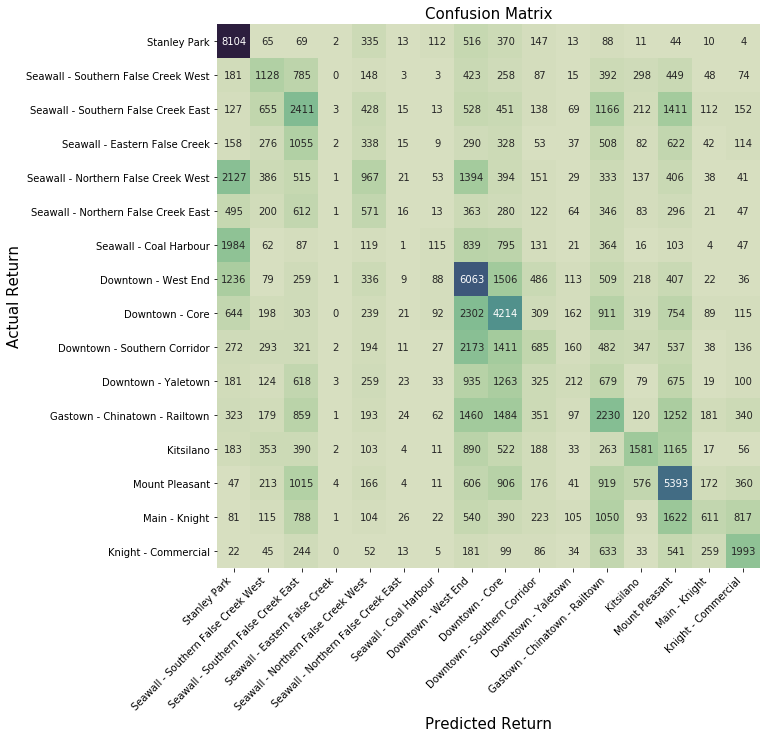

In [19]:
custom_confusion_matrix(y_test, LR_y_pred_list[2], region_label_df)

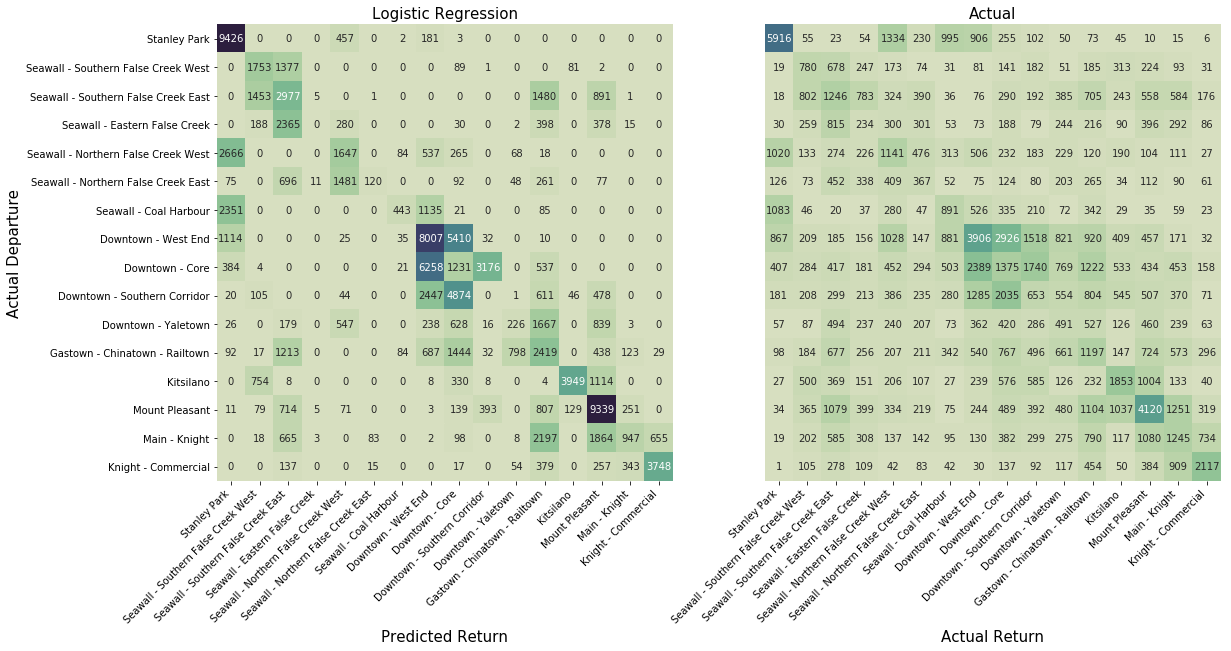

In [20]:
custom_departure_return_matrix(y_actual_departure, y_actual_return, LR_y_pred_list[2], region_label_df, 'Logistic Regression')

#### Support Vector Machines

In [21]:
from sklearn.svm import LinearSVC

LSVC_model = LinearSVC(multi_class  = 'ovr', verbose=2, max_iter=200)
LSVC_model.fit(X_train_NN_scaled, y_train)

import warnings
warnings.filterwarnings('ignore')

[LibLinear]

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [22]:
SVC_y_pred_list = custom_predict(LSVC_model, X_train_NN_scaled, X_valid_NN_scaled, X_test_NN_scaled)
SVC_score = custom_model_score(SVC_y_pred_list, y_train, y_valid, y_test, ctype='Classification')

output = custom_score_display(SVC_score, ctype='Classification')
output.loc[:,output.columns.str.contains('Test')]

,Test - Accuracy,Test - Precision,Test - Recall,Test - F1
0,0.302206,0.264152,0.247521,0.223782


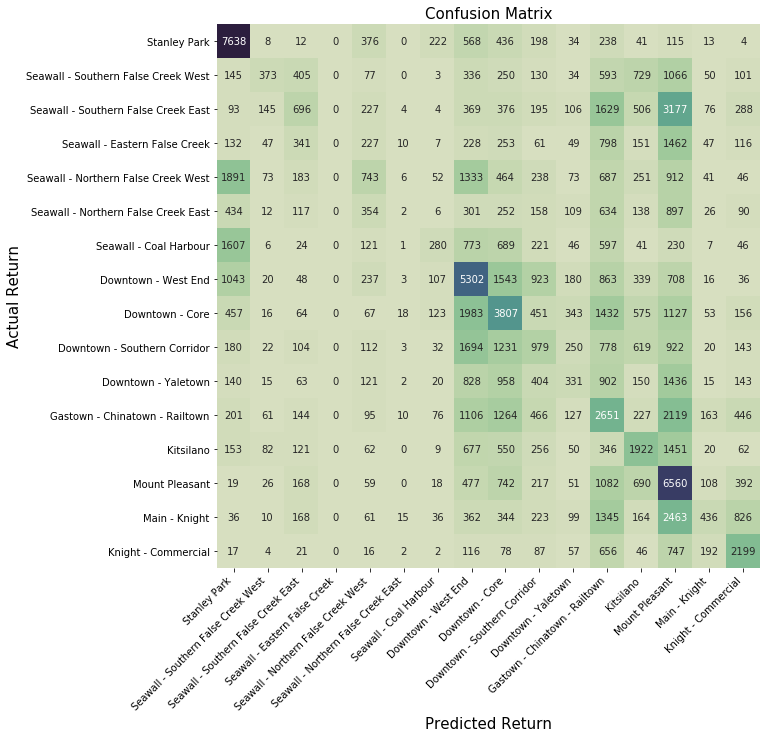

In [23]:
custom_confusion_matrix(y_test, SVC_y_pred_list[2], region_label_df)

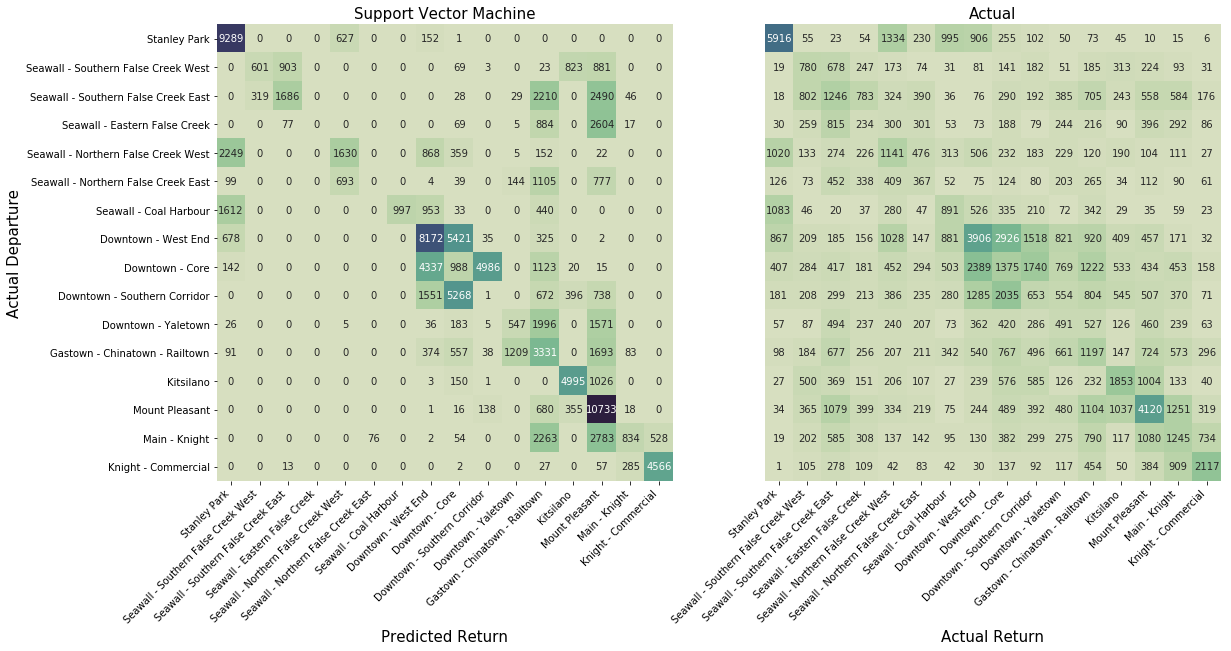

In [24]:
custom_departure_return_matrix(y_actual_departure, y_actual_return, SVC_y_pred_list[2], region_label_df, 'Support Vector Machine')

#### LightGBM

In [25]:
from lightgbm  import LGBMClassifier

LGBM_model = LGBMClassifier(max_depth = 5, learning_rate = 0.1, n_estimators=200)
LGBM_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=5)

[1]	valid_0's multi_logloss: 2.57834
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 2.53053
[3]	valid_0's multi_logloss: 2.49177
[4]	valid_0's multi_logloss: 2.45921
[5]	valid_0's multi_logloss: 2.43154
[6]	valid_0's multi_logloss: 2.40758
[7]	valid_0's multi_logloss: 2.38658
[8]	valid_0's multi_logloss: 2.36791
[9]	valid_0's multi_logloss: 2.35104
[10]	valid_0's multi_logloss: 2.33606
[11]	valid_0's multi_logloss: 2.32258
[12]	valid_0's multi_logloss: 2.31028
[13]	valid_0's multi_logloss: 2.29897
[14]	valid_0's multi_logloss: 2.28875
[15]	valid_0's multi_logloss: 2.27947
[16]	valid_0's multi_logloss: 2.27082
[17]	valid_0's multi_logloss: 2.26283
[18]	valid_0's multi_logloss: 2.25563
[19]	valid_0's multi_logloss: 2.24885
[20]	valid_0's multi_logloss: 2.24248
[21]	valid_0's multi_logloss: 2.23661
[22]	valid_0's multi_logloss: 2.23091
[23]	valid_0's multi_logloss: 2.22579
[24]	valid_0's multi_logloss: 2.2211
[25]	valid_0's multi_logloss: 2.21637

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=5,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [26]:
LGBM_y_pred_list = custom_predict(LGBM_model, X_train, X_valid, X_test)

In [27]:
LGBM_score = custom_model_score(LGBM_y_pred_list, y_train, y_valid, y_test, ctype='Classification')
output = custom_score_display(LGBM_score, ctype='Classification')
output.loc[:,output.columns.str.contains('Test')]

,Test - Accuracy,Test - Precision,Test - Recall,Test - F1
0,0.34475,0.340425,0.294867,0.282027


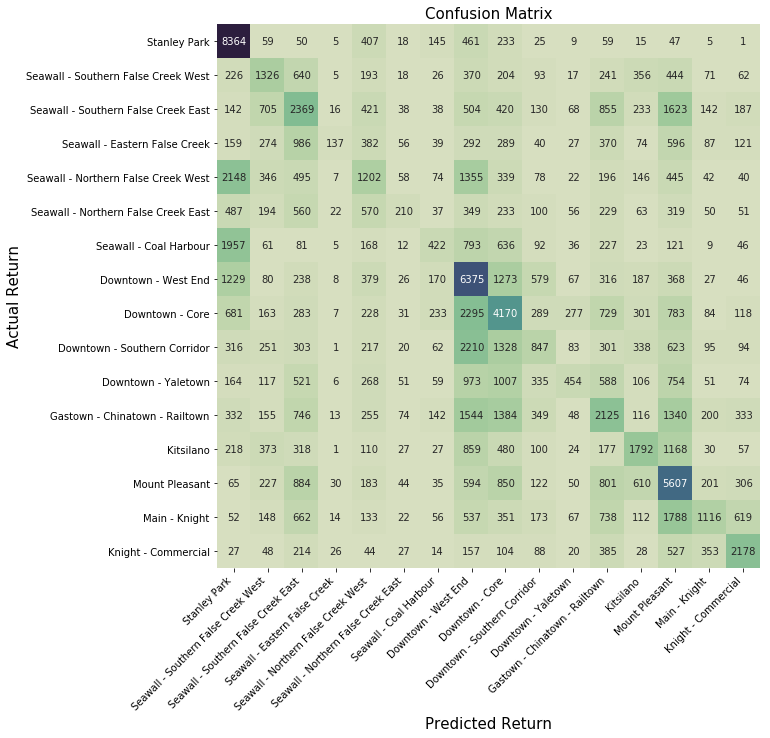

In [29]:
custom_confusion_matrix(y_test, LGBM_y_pred_list[2], region_label_df)

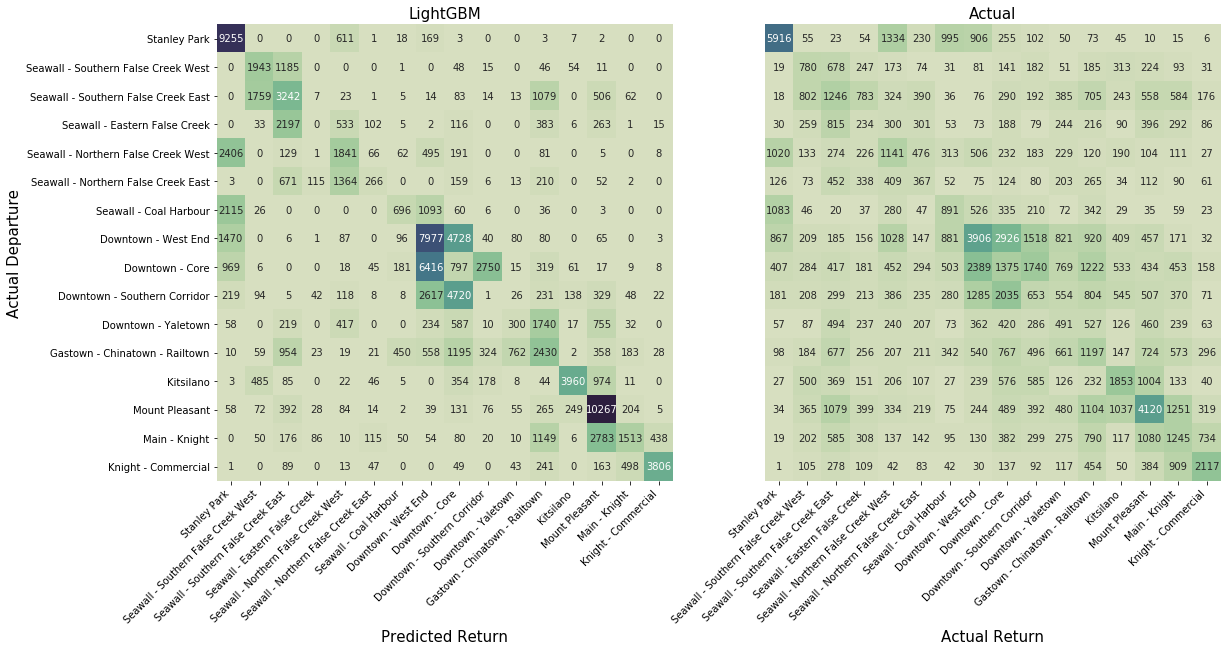

In [30]:
custom_departure_return_matrix(y_actual_departure, y_actual_return, LGBM_y_pred_list[2], region_label_df, 'LightGBM')

#### CatBoost

In [32]:
from catboost import CatBoostClassifier

CB_model = CatBoostClassifier(max_depth = 5, learning_rate = 0.1, n_estimators=1500, task_type='GPU')
CB_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=5, use_best_model=True)

0:	learn: 2.6644135	test: 2.6646600	best: 2.6646600 (0)	total: 102ms	remaining: 2m 32s
1:	learn: 2.6017991	test: 2.6021251	best: 2.6021251 (1)	total: 201ms	remaining: 2m 30s
2:	learn: 2.5558791	test: 2.5562825	best: 2.5562825 (2)	total: 299ms	remaining: 2m 29s
3:	learn: 2.5160634	test: 2.5164571	best: 2.5164571 (3)	total: 398ms	remaining: 2m 28s
4:	learn: 2.4851578	test: 2.4856886	best: 2.4856886 (4)	total: 493ms	remaining: 2m 27s
5:	learn: 2.4570679	test: 2.4576593	best: 2.4576593 (5)	total: 588ms	remaining: 2m 26s
6:	learn: 2.4345125	test: 2.4351321	best: 2.4351321 (6)	total: 680ms	remaining: 2m 24s
7:	learn: 2.4176244	test: 2.4182493	best: 2.4182493 (7)	total: 772ms	remaining: 2m 23s
8:	learn: 2.4001913	test: 2.4007818	best: 2.4007818 (8)	total: 870ms	remaining: 2m 24s
9:	learn: 2.3813686	test: 2.3817361	best: 2.3817361 (9)	total: 965ms	remaining: 2m 23s
10:	learn: 2.3677226	test: 2.3681814	best: 2.3681814 (10)	total: 1.06s	remaining: 2m 23s
11:	learn: 2.3543031	test: 2.3547965	best

95:	learn: 2.1773439	test: 2.1792007	best: 2.1792007 (95)	total: 8.94s	remaining: 2m 10s
96:	learn: 2.1768085	test: 2.1787041	best: 2.1787041 (96)	total: 9.03s	remaining: 2m 10s
97:	learn: 2.1762393	test: 2.1781630	best: 2.1781630 (97)	total: 9.12s	remaining: 2m 10s
98:	learn: 2.1756094	test: 2.1775415	best: 2.1775415 (98)	total: 9.21s	remaining: 2m 10s
99:	learn: 2.1749136	test: 2.1768442	best: 2.1768442 (99)	total: 9.3s	remaining: 2m 10s
100:	learn: 2.1743329	test: 2.1762950	best: 2.1762950 (100)	total: 9.39s	remaining: 2m 10s
101:	learn: 2.1736220	test: 2.1755874	best: 2.1755874 (101)	total: 9.49s	remaining: 2m 10s
102:	learn: 2.1728555	test: 2.1748681	best: 2.1748681 (102)	total: 9.58s	remaining: 2m 9s
103:	learn: 2.1721754	test: 2.1742195	best: 2.1742195 (103)	total: 9.67s	remaining: 2m 9s
104:	learn: 2.1715740	test: 2.1736559	best: 2.1736559 (104)	total: 9.76s	remaining: 2m 9s
105:	learn: 2.1710205	test: 2.1730963	best: 2.1730963 (105)	total: 9.86s	remaining: 2m 9s
106:	learn: 2.

189:	learn: 2.1298658	test: 2.1334185	best: 2.1334185 (189)	total: 17.6s	remaining: 2m 1s
190:	learn: 2.1295015	test: 2.1330685	best: 2.1330685 (190)	total: 17.7s	remaining: 2m 1s
191:	learn: 2.1292000	test: 2.1327818	best: 2.1327818 (191)	total: 17.8s	remaining: 2m
192:	learn: 2.1288824	test: 2.1324703	best: 2.1324703 (192)	total: 17.8s	remaining: 2m
193:	learn: 2.1285296	test: 2.1321351	best: 2.1321351 (193)	total: 17.9s	remaining: 2m
194:	learn: 2.1283035	test: 2.1318957	best: 2.1318957 (194)	total: 18s	remaining: 2m
195:	learn: 2.1278647	test: 2.1314894	best: 2.1314894 (195)	total: 18.1s	remaining: 2m
196:	learn: 2.1275487	test: 2.1311622	best: 2.1311622 (196)	total: 18.2s	remaining: 2m
197:	learn: 2.1272687	test: 2.1309148	best: 2.1309148 (197)	total: 18.3s	remaining: 2m
198:	learn: 2.1268582	test: 2.1304906	best: 2.1304906 (198)	total: 18.4s	remaining: 2m
199:	learn: 2.1265001	test: 2.1301306	best: 2.1301306 (199)	total: 18.5s	remaining: 2m
200:	learn: 2.1261719	test: 2.1298068	b

281:	learn: 2.1014672	test: 2.1063086	best: 2.1063086 (281)	total: 26s	remaining: 1m 52s
282:	learn: 2.1011354	test: 2.1059806	best: 2.1059806 (282)	total: 26.1s	remaining: 1m 52s
283:	learn: 2.1008927	test: 2.1057493	best: 2.1057493 (283)	total: 26.2s	remaining: 1m 52s
284:	learn: 2.1006031	test: 2.1055080	best: 2.1055080 (284)	total: 26.3s	remaining: 1m 52s
285:	learn: 2.1002975	test: 2.1052183	best: 2.1052183 (285)	total: 26.4s	remaining: 1m 51s
286:	learn: 2.1000784	test: 2.1050152	best: 2.1050152 (286)	total: 26.5s	remaining: 1m 51s
287:	learn: 2.0998686	test: 2.1048325	best: 2.1048325 (287)	total: 26.6s	remaining: 1m 51s
288:	learn: 2.0996211	test: 2.1045846	best: 2.1045846 (288)	total: 26.7s	remaining: 1m 51s
289:	learn: 2.0993427	test: 2.1043516	best: 2.1043516 (289)	total: 26.7s	remaining: 1m 51s
290:	learn: 2.0990421	test: 2.1040695	best: 2.1040695 (290)	total: 26.8s	remaining: 1m 51s
291:	learn: 2.0988725	test: 2.1039172	best: 2.1039172 (291)	total: 26.9s	remaining: 1m 51s
2

372:	learn: 2.0814358	test: 2.0874776	best: 2.0874776 (372)	total: 34.4s	remaining: 1m 43s
373:	learn: 2.0812903	test: 2.0873445	best: 2.0873445 (373)	total: 34.5s	remaining: 1m 43s
374:	learn: 2.0810207	test: 2.0871088	best: 2.0871088 (374)	total: 34.6s	remaining: 1m 43s
375:	learn: 2.0808033	test: 2.0869191	best: 2.0869191 (375)	total: 34.7s	remaining: 1m 43s
376:	learn: 2.0805698	test: 2.0866989	best: 2.0866989 (376)	total: 34.8s	remaining: 1m 43s
377:	learn: 2.0803980	test: 2.0865365	best: 2.0865365 (377)	total: 34.8s	remaining: 1m 43s
378:	learn: 2.0801489	test: 2.0863039	best: 2.0863039 (378)	total: 34.9s	remaining: 1m 43s
379:	learn: 2.0799150	test: 2.0860916	best: 2.0860916 (379)	total: 35s	remaining: 1m 43s
380:	learn: 2.0797217	test: 2.0859158	best: 2.0859158 (380)	total: 35.1s	remaining: 1m 43s
381:	learn: 2.0795148	test: 2.0857196	best: 2.0857196 (381)	total: 35.2s	remaining: 1m 43s
382:	learn: 2.0793438	test: 2.0855507	best: 2.0855507 (382)	total: 35.3s	remaining: 1m 42s
3

464:	learn: 2.0654901	test: 2.0726381	best: 2.0726381 (464)	total: 42.9s	remaining: 1m 35s
465:	learn: 2.0653762	test: 2.0725122	best: 2.0725122 (465)	total: 43s	remaining: 1m 35s
466:	learn: 2.0652225	test: 2.0723755	best: 2.0723755 (466)	total: 43s	remaining: 1m 35s
467:	learn: 2.0651024	test: 2.0722562	best: 2.0722562 (467)	total: 43.1s	remaining: 1m 35s
468:	learn: 2.0649894	test: 2.0721617	best: 2.0721617 (468)	total: 43.2s	remaining: 1m 35s
469:	learn: 2.0648617	test: 2.0720460	best: 2.0720460 (469)	total: 43.3s	remaining: 1m 34s
470:	learn: 2.0647390	test: 2.0719130	best: 2.0719130 (470)	total: 43.4s	remaining: 1m 34s
471:	learn: 2.0645994	test: 2.0717838	best: 2.0717838 (471)	total: 43.5s	remaining: 1m 34s
472:	learn: 2.0644823	test: 2.0716691	best: 2.0716691 (472)	total: 43.6s	remaining: 1m 34s
473:	learn: 2.0642888	test: 2.0714809	best: 2.0714809 (473)	total: 43.7s	remaining: 1m 34s
474:	learn: 2.0641315	test: 2.0713412	best: 2.0713412 (474)	total: 43.8s	remaining: 1m 34s
475

556:	learn: 2.0534528	test: 2.0615150	best: 2.0615150 (556)	total: 51.3s	remaining: 1m 26s
557:	learn: 2.0532753	test: 2.0613525	best: 2.0613525 (557)	total: 51.4s	remaining: 1m 26s
558:	learn: 2.0531600	test: 2.0612529	best: 2.0612529 (558)	total: 51.5s	remaining: 1m 26s
559:	learn: 2.0530254	test: 2.0611156	best: 2.0611156 (559)	total: 51.6s	remaining: 1m 26s
560:	learn: 2.0529158	test: 2.0610253	best: 2.0610253 (560)	total: 51.7s	remaining: 1m 26s
561:	learn: 2.0527992	test: 2.0609045	best: 2.0609045 (561)	total: 51.8s	remaining: 1m 26s
562:	learn: 2.0526901	test: 2.0608061	best: 2.0608061 (562)	total: 51.9s	remaining: 1m 26s
563:	learn: 2.0525874	test: 2.0606949	best: 2.0606949 (563)	total: 52s	remaining: 1m 26s
564:	learn: 2.0524537	test: 2.0605759	best: 2.0605759 (564)	total: 52s	remaining: 1m 26s
565:	learn: 2.0523496	test: 2.0604752	best: 2.0604752 (565)	total: 52.1s	remaining: 1m 26s
566:	learn: 2.0522837	test: 2.0604117	best: 2.0604117 (566)	total: 52.2s	remaining: 1m 25s
567

649:	learn: 2.0425739	test: 2.0515265	best: 2.0515265 (649)	total: 59.9s	remaining: 1m 18s
650:	learn: 2.0424501	test: 2.0513934	best: 2.0513934 (650)	total: 60s	remaining: 1m 18s
651:	learn: 2.0423655	test: 2.0513212	best: 2.0513212 (651)	total: 1m	remaining: 1m 18s
652:	learn: 2.0422026	test: 2.0511814	best: 2.0511814 (652)	total: 1m	remaining: 1m 18s
653:	learn: 2.0421015	test: 2.0511003	best: 2.0511003 (653)	total: 1m	remaining: 1m 17s
654:	learn: 2.0419851	test: 2.0510058	best: 2.0510058 (654)	total: 1m	remaining: 1m 17s
655:	learn: 2.0418785	test: 2.0509151	best: 2.0509151 (655)	total: 1m	remaining: 1m 17s
656:	learn: 2.0417533	test: 2.0507902	best: 2.0507902 (656)	total: 1m	remaining: 1m 17s
657:	learn: 2.0416694	test: 2.0507051	best: 2.0507051 (657)	total: 1m	remaining: 1m 17s
658:	learn: 2.0415566	test: 2.0506152	best: 2.0506152 (658)	total: 1m	remaining: 1m 17s
659:	learn: 2.0414755	test: 2.0505321	best: 2.0505321 (659)	total: 1m	remaining: 1m 17s
660:	learn: 2.0413561	test: 

741:	learn: 2.0333414	test: 2.0431691	best: 2.0431691 (741)	total: 1m 8s	remaining: 1m 9s
742:	learn: 2.0332877	test: 2.0431195	best: 2.0431195 (742)	total: 1m 8s	remaining: 1m 9s
743:	learn: 2.0331796	test: 2.0430187	best: 2.0430187 (743)	total: 1m 8s	remaining: 1m 9s
744:	learn: 2.0330857	test: 2.0429314	best: 2.0429314 (744)	total: 1m 8s	remaining: 1m 9s
745:	learn: 2.0330180	test: 2.0428607	best: 2.0428607 (745)	total: 1m 8s	remaining: 1m 9s
746:	learn: 2.0329228	test: 2.0427783	best: 2.0427783 (746)	total: 1m 8s	remaining: 1m 9s
747:	learn: 2.0328519	test: 2.0427095	best: 2.0427095 (747)	total: 1m 8s	remaining: 1m 9s
748:	learn: 2.0327633	test: 2.0426263	best: 2.0426263 (748)	total: 1m 8s	remaining: 1m 9s
749:	learn: 2.0326642	test: 2.0425279	best: 2.0425279 (749)	total: 1m 9s	remaining: 1m 9s
750:	learn: 2.0325854	test: 2.0424553	best: 2.0424553 (750)	total: 1m 9s	remaining: 1m 8s
751:	learn: 2.0325306	test: 2.0423992	best: 2.0423992 (751)	total: 1m 9s	remaining: 1m 8s
752:	learn

833:	learn: 2.0253225	test: 2.0359384	best: 2.0359384 (833)	total: 1m 16s	remaining: 1m 1s
834:	learn: 2.0251984	test: 2.0358250	best: 2.0358250 (834)	total: 1m 16s	remaining: 1m 1s
835:	learn: 2.0251242	test: 2.0357573	best: 2.0357573 (835)	total: 1m 16s	remaining: 1m 1s
836:	learn: 2.0250165	test: 2.0356696	best: 2.0356696 (836)	total: 1m 17s	remaining: 1m 1s
837:	learn: 2.0249250	test: 2.0355849	best: 2.0355849 (837)	total: 1m 17s	remaining: 1m
838:	learn: 2.0248153	test: 2.0354872	best: 2.0354872 (838)	total: 1m 17s	remaining: 1m
839:	learn: 2.0247505	test: 2.0354149	best: 2.0354149 (839)	total: 1m 17s	remaining: 1m
840:	learn: 2.0246830	test: 2.0353598	best: 2.0353598 (840)	total: 1m 17s	remaining: 1m
841:	learn: 2.0245758	test: 2.0352676	best: 2.0352676 (841)	total: 1m 17s	remaining: 1m
842:	learn: 2.0245128	test: 2.0352192	best: 2.0352192 (842)	total: 1m 17s	remaining: 1m
843:	learn: 2.0244359	test: 2.0351591	best: 2.0351591 (843)	total: 1m 17s	remaining: 1m
844:	learn: 2.024331

925:	learn: 2.0181316	test: 2.0295711	best: 2.0295711 (925)	total: 1m 25s	remaining: 52.9s
926:	learn: 2.0180470	test: 2.0295002	best: 2.0295002 (926)	total: 1m 25s	remaining: 52.8s
927:	learn: 2.0179925	test: 2.0294447	best: 2.0294447 (927)	total: 1m 25s	remaining: 52.7s
928:	learn: 2.0179058	test: 2.0293658	best: 2.0293658 (928)	total: 1m 25s	remaining: 52.6s
929:	learn: 2.0178288	test: 2.0292929	best: 2.0292929 (929)	total: 1m 25s	remaining: 52.5s
930:	learn: 2.0177546	test: 2.0292256	best: 2.0292256 (930)	total: 1m 25s	remaining: 52.4s
931:	learn: 2.0176771	test: 2.0291513	best: 2.0291513 (931)	total: 1m 25s	remaining: 52.3s
932:	learn: 2.0176385	test: 2.0291249	best: 2.0291249 (932)	total: 1m 25s	remaining: 52.2s
933:	learn: 2.0175578	test: 2.0290483	best: 2.0290483 (933)	total: 1m 26s	remaining: 52.1s
934:	learn: 2.0174776	test: 2.0289993	best: 2.0289993 (934)	total: 1m 26s	remaining: 52.1s
935:	learn: 2.0174267	test: 2.0289485	best: 2.0289485 (935)	total: 1m 26s	remaining: 52s
9

1016:	learn: 2.0118028	test: 2.0240210	best: 2.0240210 (1016)	total: 1m 33s	remaining: 44.5s
1017:	learn: 2.0117286	test: 2.0239524	best: 2.0239524 (1017)	total: 1m 33s	remaining: 44.4s
1018:	learn: 2.0116352	test: 2.0238703	best: 2.0238703 (1018)	total: 1m 33s	remaining: 44.3s
1019:	learn: 2.0115885	test: 2.0238309	best: 2.0238309 (1019)	total: 1m 33s	remaining: 44.2s
1020:	learn: 2.0115002	test: 2.0237571	best: 2.0237571 (1020)	total: 1m 34s	remaining: 44.1s
1021:	learn: 2.0114379	test: 2.0237068	best: 2.0237068 (1021)	total: 1m 34s	remaining: 44s
1022:	learn: 2.0113729	test: 2.0236437	best: 2.0236437 (1022)	total: 1m 34s	remaining: 44s
1023:	learn: 2.0113117	test: 2.0235900	best: 2.0235900 (1023)	total: 1m 34s	remaining: 43.9s
1024:	learn: 2.0112345	test: 2.0235247	best: 2.0235247 (1024)	total: 1m 34s	remaining: 43.8s
1025:	learn: 2.0111773	test: 2.0234739	best: 2.0234739 (1025)	total: 1m 34s	remaining: 43.7s
1026:	learn: 2.0110758	test: 2.0233826	best: 2.0233826 (1026)	total: 1m 34

1106:	learn: 2.0058000	test: 2.0187655	best: 2.0187655 (1106)	total: 1m 42s	remaining: 36.2s
1107:	learn: 2.0057474	test: 2.0187221	best: 2.0187221 (1107)	total: 1m 42s	remaining: 36.1s
1108:	learn: 2.0056900	test: 2.0186742	best: 2.0186742 (1108)	total: 1m 42s	remaining: 36s
1109:	learn: 2.0056568	test: 2.0186408	best: 2.0186408 (1109)	total: 1m 42s	remaining: 36s
1110:	learn: 2.0055745	test: 2.0185677	best: 2.0185677 (1110)	total: 1m 42s	remaining: 35.9s
1111:	learn: 2.0054866	test: 2.0185021	best: 2.0185021 (1111)	total: 1m 42s	remaining: 35.8s
1112:	learn: 2.0054395	test: 2.0184656	best: 2.0184656 (1112)	total: 1m 42s	remaining: 35.7s
1113:	learn: 2.0053943	test: 2.0184266	best: 2.0184266 (1113)	total: 1m 42s	remaining: 35.6s
1114:	learn: 2.0053374	test: 2.0183884	best: 2.0183884 (1114)	total: 1m 42s	remaining: 35.5s
1115:	learn: 2.0052431	test: 2.0183218	best: 2.0183218 (1115)	total: 1m 42s	remaining: 35.4s
1116:	learn: 2.0051858	test: 2.0182693	best: 2.0182693 (1116)	total: 1m 42

1195:	learn: 2.0003551	test: 2.0139737	best: 2.0139737 (1195)	total: 1m 50s	remaining: 28s
1196:	learn: 2.0002865	test: 2.0139104	best: 2.0139104 (1196)	total: 1m 50s	remaining: 27.9s
1197:	learn: 2.0002245	test: 2.0138598	best: 2.0138598 (1197)	total: 1m 50s	remaining: 27.8s
1198:	learn: 2.0001837	test: 2.0138239	best: 2.0138239 (1198)	total: 1m 50s	remaining: 27.8s
1199:	learn: 2.0001287	test: 2.0137746	best: 2.0137746 (1199)	total: 1m 50s	remaining: 27.7s
1200:	learn: 2.0001024	test: 2.0137533	best: 2.0137533 (1200)	total: 1m 50s	remaining: 27.6s
1201:	learn: 2.0000566	test: 2.0137137	best: 2.0137137 (1201)	total: 1m 50s	remaining: 27.5s
1202:	learn: 2.0000124	test: 2.0136794	best: 2.0136794 (1202)	total: 1m 50s	remaining: 27.4s
1203:	learn: 1.9999714	test: 2.0136482	best: 2.0136482 (1203)	total: 1m 51s	remaining: 27.3s
1204:	learn: 1.9998510	test: 2.0135675	best: 2.0135675 (1204)	total: 1m 51s	remaining: 27.2s
1205:	learn: 1.9997857	test: 2.0135113	best: 2.0135113 (1205)	total: 1m 

1285:	learn: 1.9950569	test: 2.0094743	best: 2.0094743 (1285)	total: 1m 58s	remaining: 19.7s
1286:	learn: 1.9949916	test: 2.0094148	best: 2.0094148 (1286)	total: 1m 58s	remaining: 19.6s
1287:	learn: 1.9949348	test: 2.0093703	best: 2.0093703 (1287)	total: 1m 58s	remaining: 19.6s
1288:	learn: 1.9948925	test: 2.0093375	best: 2.0093375 (1288)	total: 1m 58s	remaining: 19.5s
1289:	learn: 1.9948445	test: 2.0092961	best: 2.0092961 (1289)	total: 1m 58s	remaining: 19.4s
1290:	learn: 1.9947876	test: 2.0092428	best: 2.0092428 (1290)	total: 1m 59s	remaining: 19.3s
1291:	learn: 1.9947163	test: 2.0091724	best: 2.0091724 (1291)	total: 1m 59s	remaining: 19.2s
1292:	learn: 1.9946597	test: 2.0091252	best: 2.0091252 (1292)	total: 1m 59s	remaining: 19.1s
1293:	learn: 1.9946082	test: 2.0090854	best: 2.0090854 (1293)	total: 1m 59s	remaining: 19s
1294:	learn: 1.9945304	test: 2.0090114	best: 2.0090114 (1294)	total: 1m 59s	remaining: 18.9s
1295:	learn: 1.9944964	test: 2.0089813	best: 2.0089813 (1295)	total: 1m 

1376:	learn: 1.9903302	test: 2.0052943	best: 2.0052943 (1376)	total: 2m 7s	remaining: 11.3s
1377:	learn: 1.9902963	test: 2.0052742	best: 2.0052742 (1377)	total: 2m 7s	remaining: 11.3s
1378:	learn: 1.9902393	test: 2.0052300	best: 2.0052300 (1378)	total: 2m 7s	remaining: 11.2s
1379:	learn: 1.9902120	test: 2.0052072	best: 2.0052072 (1379)	total: 2m 7s	remaining: 11.1s
1380:	learn: 1.9901640	test: 2.0051742	best: 2.0051742 (1380)	total: 2m 7s	remaining: 11s
1381:	learn: 1.9901243	test: 2.0051376	best: 2.0051376 (1381)	total: 2m 7s	remaining: 10.9s
1382:	learn: 1.9900513	test: 2.0050652	best: 2.0050652 (1382)	total: 2m 7s	remaining: 10.8s
1383:	learn: 1.9899939	test: 2.0050100	best: 2.0050100 (1383)	total: 2m 7s	remaining: 10.7s
1384:	learn: 1.9899463	test: 2.0049649	best: 2.0049649 (1384)	total: 2m 7s	remaining: 10.6s
1385:	learn: 1.9898978	test: 2.0049208	best: 2.0049208 (1385)	total: 2m 7s	remaining: 10.5s
1386:	learn: 1.9898539	test: 2.0048964	best: 2.0048964 (1386)	total: 2m 7s	remaini

1467:	learn: 1.9857689	test: 2.0014287	best: 2.0014287 (1467)	total: 2m 15s	remaining: 2.96s
1468:	learn: 1.9857111	test: 2.0013727	best: 2.0013727 (1468)	total: 2m 15s	remaining: 2.86s
1469:	learn: 1.9856683	test: 2.0013354	best: 2.0013354 (1469)	total: 2m 15s	remaining: 2.77s
1470:	learn: 1.9856001	test: 2.0012876	best: 2.0012876 (1470)	total: 2m 15s	remaining: 2.68s
1471:	learn: 1.9855629	test: 2.0012476	best: 2.0012476 (1471)	total: 2m 15s	remaining: 2.58s
1472:	learn: 1.9855134	test: 2.0012024	best: 2.0012024 (1472)	total: 2m 16s	remaining: 2.49s
1473:	learn: 1.9854694	test: 2.0011660	best: 2.0011660 (1473)	total: 2m 16s	remaining: 2.4s
1474:	learn: 1.9853945	test: 2.0011062	best: 2.0011062 (1474)	total: 2m 16s	remaining: 2.31s
1475:	learn: 1.9853534	test: 2.0010718	best: 2.0010718 (1475)	total: 2m 16s	remaining: 2.22s
1476:	learn: 1.9853252	test: 2.0010497	best: 2.0010497 (1476)	total: 2m 16s	remaining: 2.12s
1477:	learn: 1.9852830	test: 2.0010074	best: 2.0010074 (1477)	total: 2m

In [33]:
CB_y_pred_list = custom_predict(CB_model, X_train, X_valid, X_test, reshape=True)

In [34]:
CB_score = custom_model_score(CB_y_pred_list, y_train, y_valid, y_test, ctype='Classification')
output = custom_score_display(CB_score, ctype='Classification')
output.loc[:,output.columns.str.contains('Test')]

,Test - Accuracy,Test - Precision,Test - Recall,Test - F1
0,0.360903,0.349642,0.308353,0.295796


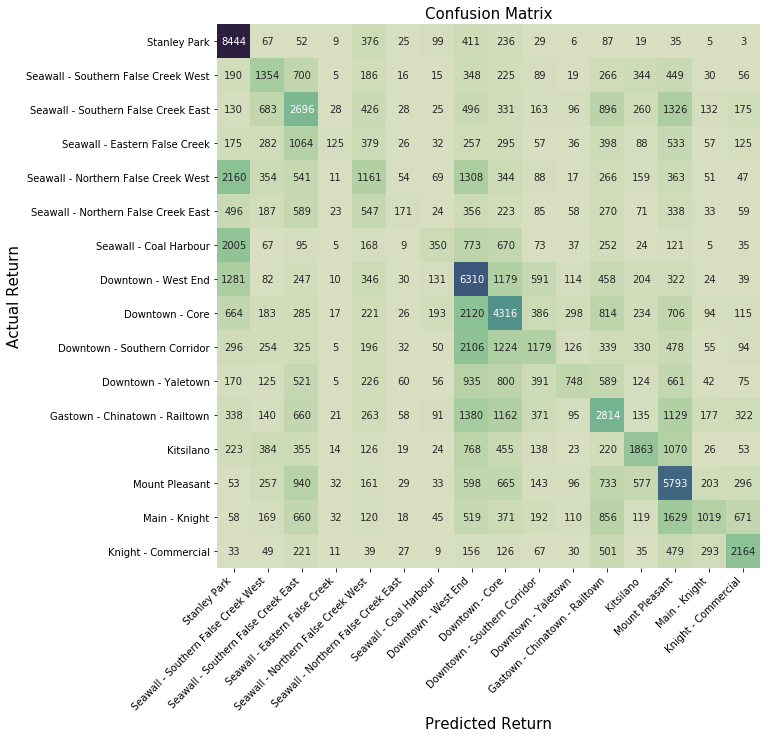

In [35]:
custom_confusion_matrix(y_test, CB_y_pred_list[2], region_label_df)

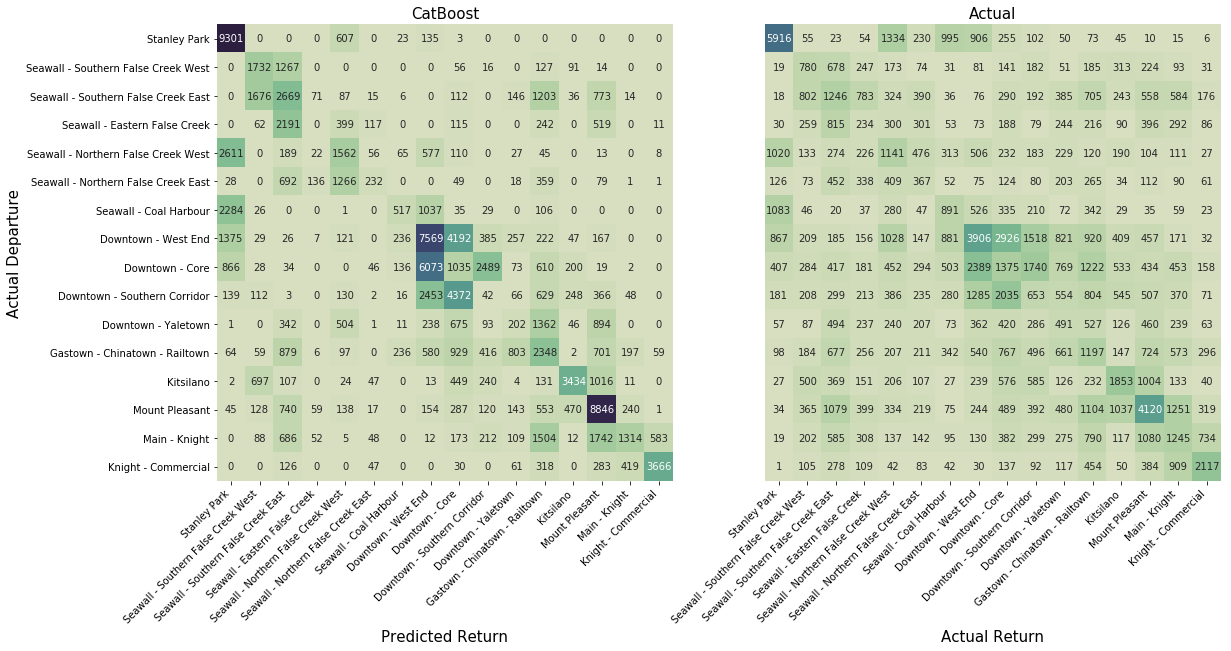

In [36]:
custom_departure_return_matrix(y_actual_departure, y_actual_return, CB_y_pred_list[2], region_label_df, 'CatBoost')

#### Neural Network - 1 Hidden Layer, 512 Neurons

In [37]:
from keras.optimizers import SGD


NN_model = Sequential()
NN_model.add(Dense(512, input_dim=X.shape[1], activation='relu'))
NN_model.add(Dropout(0.4))
NN_model.add(BatchNormalization())
NN_model.add(Dense(16, activation="softmax"))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
NN_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=adam,
              metrics=["accuracy"])


es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                   verbose=0, mode='auto', baseline=None, restore_best_weights=True)


history = NN_model.fit(X_train_NN_scaled, y_train, epochs=200, verbose=1, batch_size=512, 
                       validation_data=(X_valid_NN_scaled, y_valid), shuffle=True, callbacks=[es])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 944910 samples, validate on 236228 samples
Epoch 1/200
944910/944910 [==============================] - 16s 17us/step - loss: 2.1419 - acc: 0.3210 - val_loss: 2.0260 - val_acc: 0.3528
Epoch 2/200
944910/944910 [==============================] - 15s 16us/step - loss: 2.0422 - acc: 0.3496 - val_loss: 1.9914 - val_acc: 0.3638
Epoch 3/200
944910/944910 [==============================] - 16s 16us/step - loss: 2.0199 - acc: 0.3567 - val_loss: 1.9747 - val_acc: 0.3697
Epoch 4/200
944910/944910 [==============================] - 16s 17us/step - loss: 2.0068 - acc: 0.3613 - val_loss: 1.9664 - val_acc: 0.3723
Epoch 5/200
944910/944910 [==============================] - 16s 17us/step - loss: 1.9976 - acc: 0.3637 - val_loss: 1.9597 - val_acc: 0.3743
Epoch 6/

Epoch 52/200
944910/944910 [==============================] - 17s 18us/step - loss: 1.9443 - acc: 0.3804 - val_loss: 1.9257 - val_acc: 0.3848


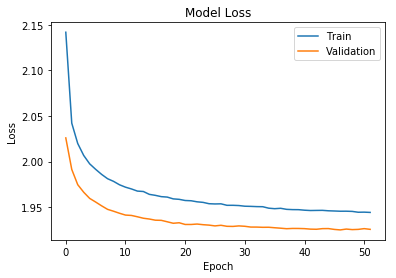

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show();

In [39]:
NN_y_pred_list = custom_predict(NN_model, X_train_NN_scaled, X_valid_NN_scaled, X_test_NN_scaled, NN_conv=True)

In [40]:
NN_score = custom_model_score(NN_y_pred_list, y_train, y_valid, y_test, ctype='Classification')
output = custom_score_display(NN_score, ctype='Classification')
output.loc[:,output.columns.str.contains('Test')]

,Test - Accuracy,Test - Precision,Test - Recall,Test - F1
0,0.372761,0.36513,0.323299,0.315965


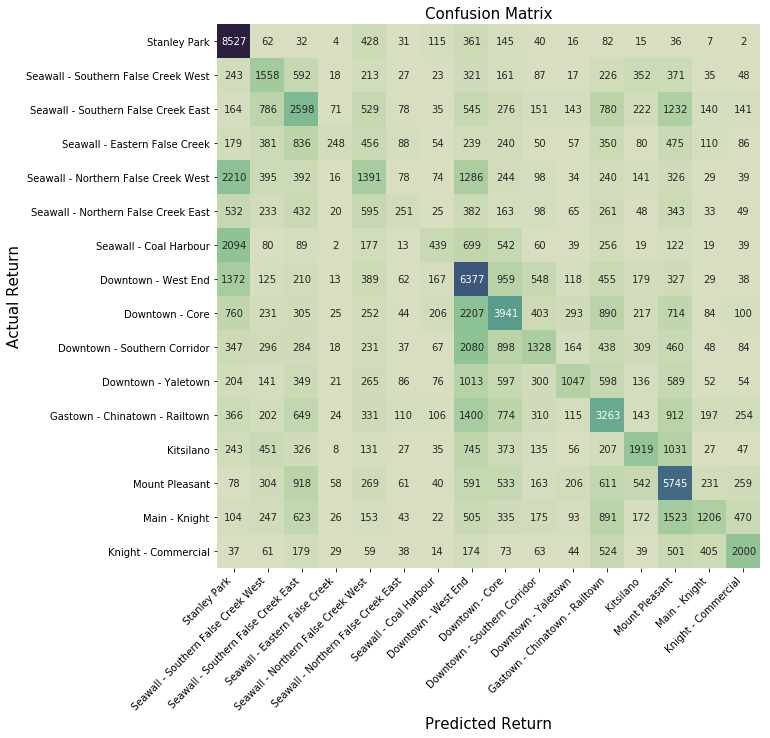

In [41]:
custom_confusion_matrix(y_test, NN_y_pred_list[2], region_label_df)

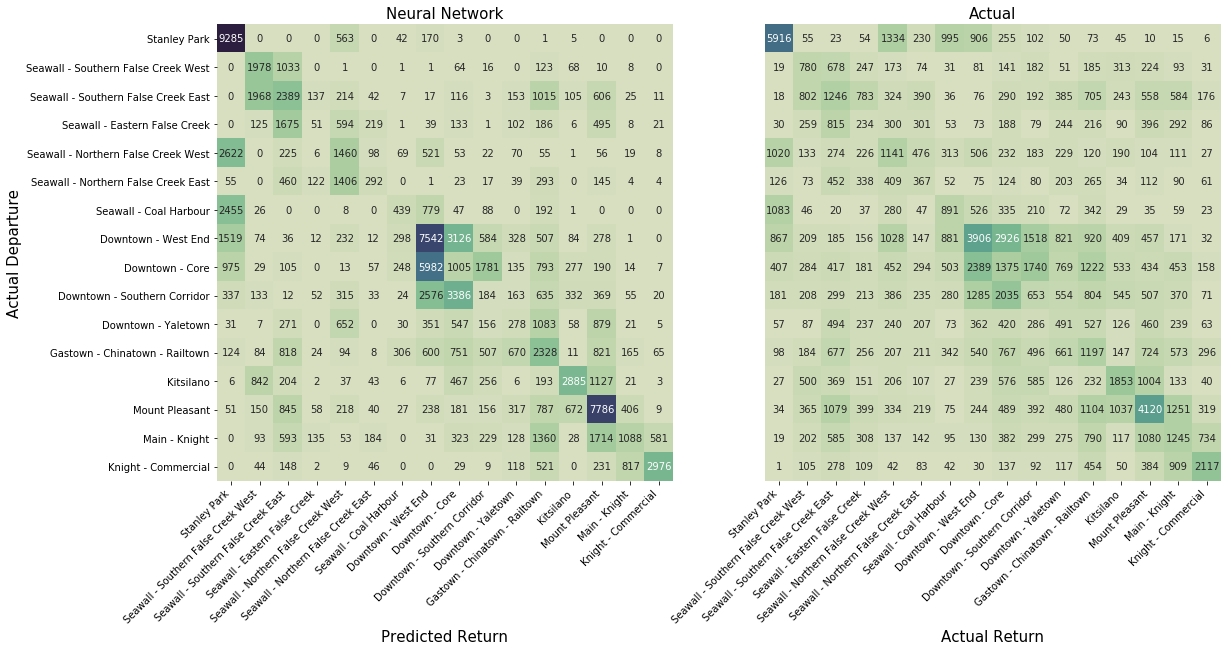

In [42]:
custom_departure_return_matrix(y_actual_departure, y_actual_return, NN_y_pred_list[2], region_label_df, 'Neural Network')

#### Neural Network - 2 Hidden Layer, 1024 and 512 Neurons

In [43]:
NN_model2 = Sequential([
    Dense(1024, input_dim=X.shape[1], activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(16, activation="softmax"),
])
NN_model2.compile(loss="sparse_categorical_crossentropy",
              optimizer=adam,
              metrics=["accuracy"])
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                   verbose=0, mode='auto', baseline=None, restore_best_weights=True)


history = NN_model2.fit(X_train_NN_scaled, y_train, epochs=200, verbose=1, batch_size=512, 
                       validation_data=(X_valid_NN_scaled, y_valid), shuffle=True, callbacks=[es])

Train on 944910 samples, validate on 236228 samples
Epoch 1/200
944910/944910 [==============================] - 24s 26us/step - loss: 2.1141 - acc: 0.3273 - val_loss: 2.0059 - val_acc: 0.3589
Epoch 2/200
944910/944910 [==============================] - 24s 25us/step - loss: 2.0255 - acc: 0.3549 - val_loss: 1.9701 - val_acc: 0.3705
Epoch 3/200
944910/944910 [==============================] - 24s 25us/step - loss: 1.9973 - acc: 0.3635 - val_loss: 1.9500 - val_acc: 0.3781
Epoch 4/200
944910/944910 [==============================] - 25s 27us/step - loss: 1.9799 - acc: 0.3688 - val_loss: 1.9385 - val_acc: 0.3797
Epoch 5/200
944910/944910 [==============================] - 25s 26us/step - loss: 1.9678 - acc: 0.3725 - val_loss: 1.9331 - val_acc: 0.3827
Epoch 6/200
944910/944910 [==============================] - 25s 27us/step - loss: 1.9577 - acc: 0.3750 - val_loss: 1.9281 - val_acc: 0.3848
Epoch 7/200
944910/944910 [==============================] - 25s 27us/step - loss: 1.9505 - acc: 0.378

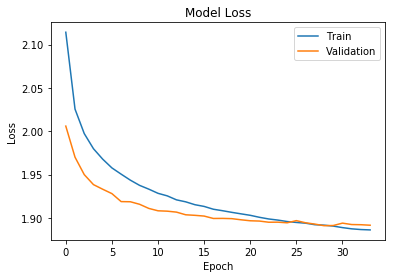

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show();

In [45]:
NN2_y_pred_list = custom_predict(NN_model2, X_train_NN_scaled, X_valid_NN_scaled, X_test_NN_scaled, NN_conv=True)

In [47]:
NN2_score = custom_model_score(NN2_y_pred_list, y_train, y_valid, y_test, ctype='Classification')
output = custom_score_display(NN2_score, ctype='Classification')
output.loc[:,output.columns.str.contains('Test')]

,Test - Accuracy,Test - Precision,Test - Recall,Test - F1
0,0.378597,0.382743,0.331135,0.325855


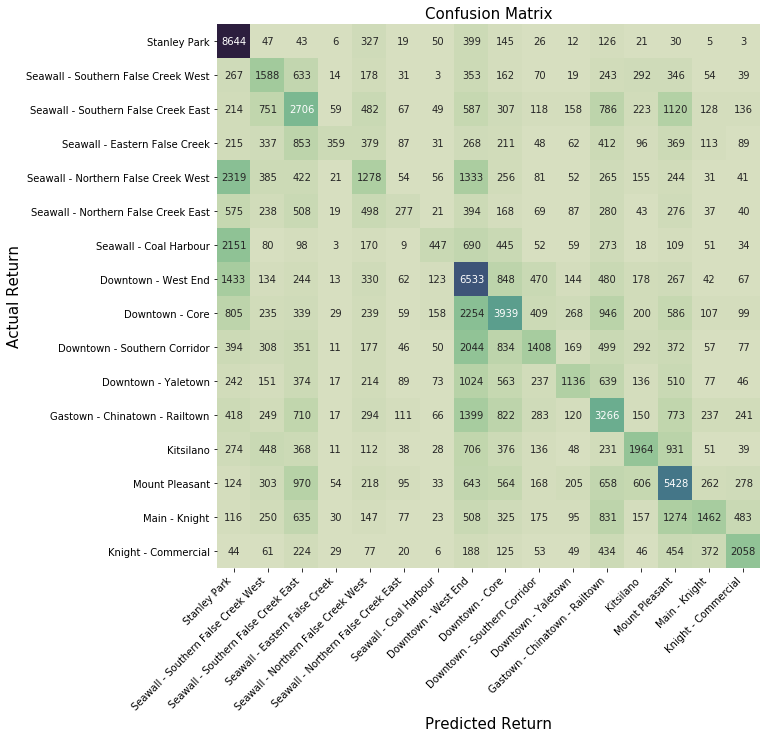

In [48]:
custom_confusion_matrix(y_test, NN2_y_pred_list[2], region_label_df)

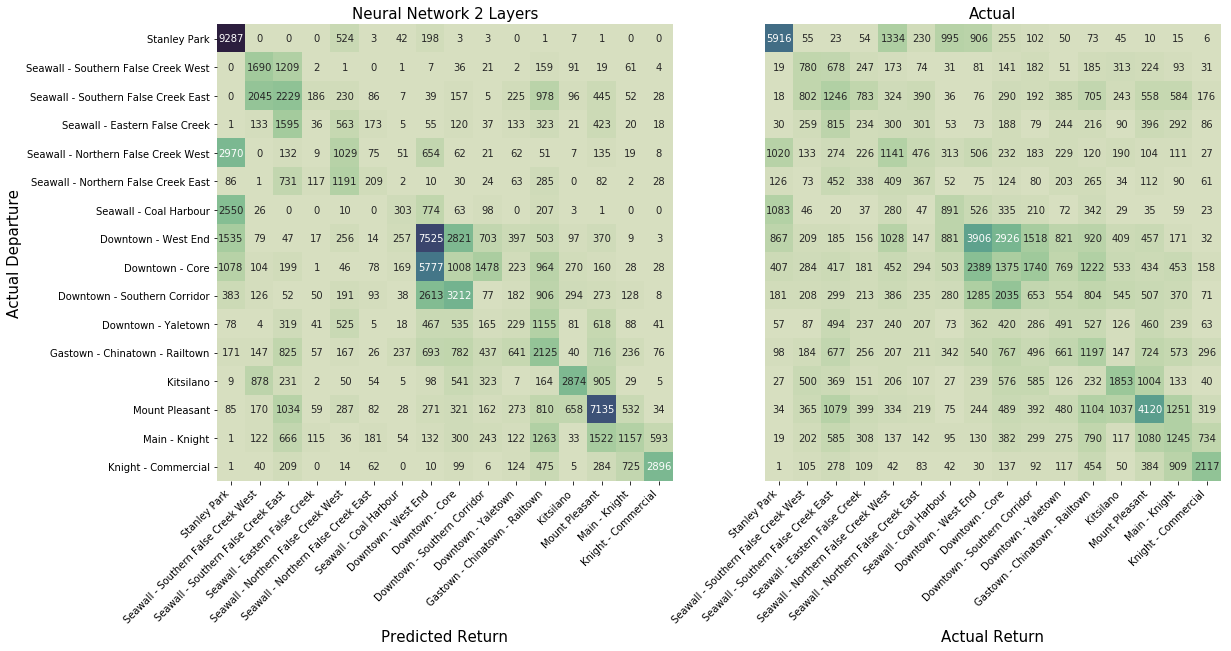

In [49]:
custom_departure_return_matrix(y_actual_departure, y_actual_return, NN2_y_pred_list[2], region_label_df, 'Neural Network 2 Layers')

In [59]:
custom_score_display([LR_score, SVC_score, LGBM_score, CB_score, NN_score, NN2_score], 
                   index=['Logistic Regression', 'Support Vector Machine', 'LightGBM', 'CatBoost', 'Neural Network [512]', 'Neural Network 2 Layer [1024, 512]'],
                   ctype='Classification')

,Training - Accuracy,Validation - Accuracy,Test - Accuracy,Training - Precision,Valid - Precision,Test - Precision,Training - Recall,Valid - Recall,Test - Recall,Training - F1,Valid - F1,Test - F1
Logistic Regression,0.316480,0.315060,0.318297,0.259046,0.255569,0.264538,0.250496,0.250064,0.262928,0.232876,0.232478,0.240017
Support Vector Machine,0.299804,0.299071,0.302206,0.253820,0.256839,0.264152,0.235902,0.235879,0.247521,0.216027,0.215786,0.223782
LightGBM,0.349977,0.346619,0.344750,0.355191,0.346938,0.340425,0.292316,0.289128,0.294867,0.285231,0.280535,0.282027
CatBoost,0.365870,0.361287,0.360903,0.362240,0.352143,0.349642,0.303573,0.299427,0.308353,0.298713,0.293333,0.295796
Neural Network [512],0.396240,0.384840,0.372761,0.412358,0.389696,0.365130,0.337006,0.324850,0.323299,0.339469,0.324731,0.315965
"Neural Network 2 Layer [1024, 512]",0.413473,0.396714,0.378597,0.438220,0.410722,0.382743,0.356785,0.338827,0.331135,0.361597,0.340792,0.325855


### Future Improvements

Adding user features was shown to increase the accuracy score of this 16 label classification problem. One future avenue that can be investigated is to utilize the Account ID column in the data set. A brief analysis of this column indicates that the anonymized ID are consistent over all the datasets. This leads me to believe that the Account ID column can be used to create features of historical movement patterns for specific users. This will probably move away from the setup in trying to use general features to classify movement patterns in the bike network.